In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from fsmodels import SklMultiExpFrequencyScan
from fsplots import plot_model
from fsplots import plot_experimental_points
from fsplots import plot_loss_path

# sklearn-compatible class

In [3]:
X = np.linspace(0, 3.5, 1000)

In [4]:
f_pulse = 20*10**-6

fs = SklMultiExpFrequencyScan(n_exps=3, filling_pulse=f_pulse)

fs.exps_params_ = [[-1.0, 3.5],
                  [-2.3, 3.0],
                  [-3.5, 2.5]]

y = fs.predict(X) 
y += np.random.normal(loc=0, scale=0.2, size=y.shape[0])

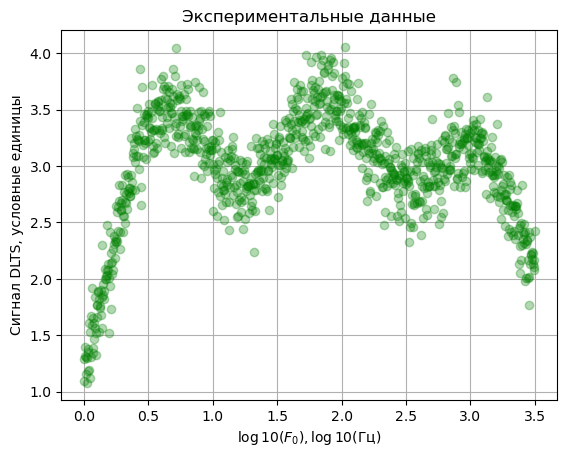

In [5]:
plot_experimental_points(X, y)
plt.show()

In [6]:
n_exps = 3

fs = SklMultiExpFrequencyScan(n_exps=n_exps, 
                              filling_pulse=f_pulse,
                              n_iters=200,
                              stop_val=10**-5,
                              verbose=True
                             )

fs.fit(X, y)

iteration # 0
loss: 9.315863957654374
exps_params:
[[-2.50596514 -0.08300391]
 [-3.37163259 -0.04362   ]
 [-1.98740819  0.08221784]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 1
loss: 8.006980333404934
exps_params:
[[-2.50928237  0.14768594]
 [-3.37720712  0.1232719 ]
 [-1.98752589  0.32076106]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 2
loss: 6.946829180280422
exps_params:
[[-2.50386535  0.35287455]
 [-3.36344504  0.27400808]
 [-1.98425213  0.53613939]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 3
loss: 6.0786693791751185
exps_params:
[[-2.49219889  0.53540402]
 [-3.3376192   0.41207752]
 [-1.97323238  0.73065151]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 4
loss:

iteration # 34
loss: 0.1731966015731616
exps_params:
[[-2.23218286  2.52837736]
 [-3.32624656  2.23994111]
 [-1.01755133  3.05698264]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 35
loss: 0.15916905123293418
exps_params:
[[-2.23427068  2.54957402]
 [-3.33395194  2.25951944]
 [-1.01606208  3.07990797]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 36
loss: 0.1466633205894239
exps_params:
[[-2.2363089   2.56967355]
 [-3.341266    2.27788771]
 [-1.01469197  3.10154298]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 37
loss: 0.13550706444887792
exps_params:
[[-2.23829112  2.5887421 ]
 [-3.34820922  2.29512263]
 [-1.01342801  3.12196636]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration 

iteration # 68
loss: 0.04251942824324027
exps_params:
[[-2.27436972  2.88639054]
 [-3.45658517  2.52158933]
 [-0.99796176  3.41426477]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 69
loss: 0.04213490046763051
exps_params:
[[-2.27495885  2.89073296]
 [-3.45813022  2.5237922 ]
 [-0.99779915  3.41776582]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 70
loss: 0.041786038135848115
exps_params:
[[-2.27552514  2.89490126]
 [-3.45960846  2.52584796]
 [-0.99764476  3.42108344]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 71
loss: 0.041469381511749136
exps_params:
[[-2.27606946  2.89890349]
 [-3.46102291  2.52776512]
 [-0.99749806  3.42422731]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iterat

iteration # 102
loss: 0.03838439523684431
exps_params:
[[-2.28566303  2.97016599]
 [-3.48464402  2.5484161 ]
 [-0.9950988   3.47031077]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 103
loss: 0.038364913582795715
exps_params:
[[-2.28582232  2.97139721]
 [-3.48500609  2.54843859]
 [-0.9950599   3.47086436]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 104
loss: 0.038346846354112625
exps_params:
[[-2.28597593  2.97258788]
 [-3.48535373  2.54844383]
 [-0.99502232  3.47138801]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 105
loss: 0.038330077360211726
exps_params:
[[-2.28612411  2.97373954]
 [-3.48568757  2.54843303]
 [-0.99498601  3.47188327]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 200
stop_val: 1e-05
verbose: True


i

SklMultiExpFrequencyScan(n_exps=3, n_iters=200, stop_val=1e-05, verbose=True)

In [7]:
fit_results = fs.fit_results_
fit_results

,amplitude_0,amplitude_1,amplitude_2,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,verbose
0,-0.083004,-0.043620,0.082218,0.00002,0.1,9.315864,3,200,0.00001,-2.505965,-3.371633,-1.987408,True
1,0.147686,0.123272,0.320761,0.00002,0.1,8.006980,3,200,0.00001,-2.509282,-3.377207,-1.987526,True
2,0.352875,0.274008,0.536139,0.00002,0.1,6.946829,3,200,0.00001,-2.503865,-3.363445,-1.984252,True
3,0.535404,0.412078,0.730652,0.00002,0.1,6.078669,3,200,0.00001,-2.492199,-3.337619,-1.973232,True
4,0.697619,0.539517,0.906296,0.00002,0.1,5.362285,3,200,0.00001,-2.476455,-3.306026,-1.951502,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2.977985,2.548251,3.473609,0.00002,0.1,0.038274,3,200,0.00001,-2.286667,-3.486896,-0.994852,True
110,2.978962,2.548176,3.473983,0.00002,0.1,0.038262,3,200,0.00001,-2.286791,-3.487170,-0.994822,True
111,2.979909,2.548090,3.474336,0.00002,0.1,0.038251,3,200,0.00001,-2.286910,-3.487432,-0.994792,True
112,2.980825,2.547996,3.474670,0.00002,0.1,0.038241,3,200,0.00001,-2.287026,-3.487685,-0.994763,True


In [8]:
fs.exps_params_

array([[-2.2871378 ,  2.98171307],
       [-3.4879274 ,  2.54789223],
       [-0.99473556,  3.47498511]])

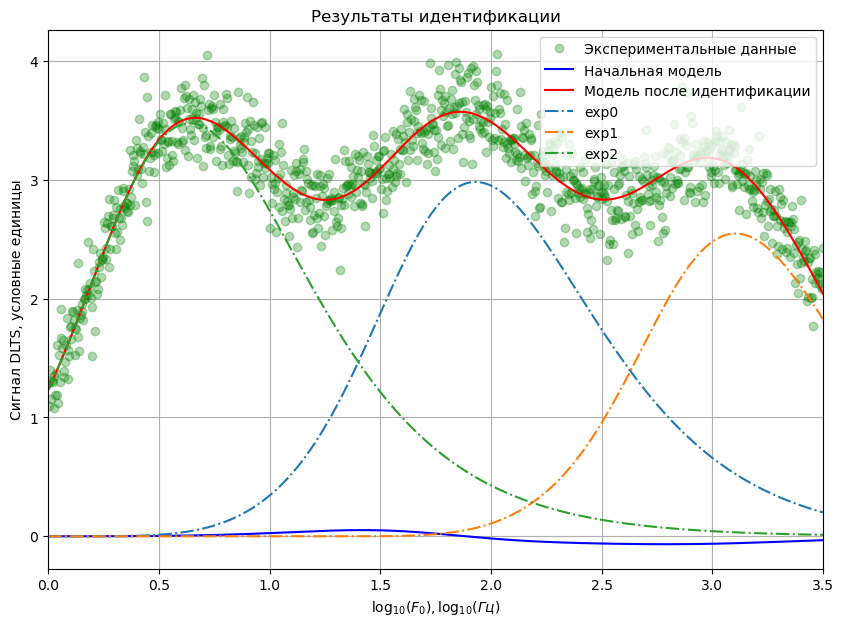

In [9]:
plot_model(X, y, SklMultiExpFrequencyScan, fs.fit_results_)
plt.show()

In [10]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'learning_rate': 0.1,
 'n_exps': 3,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': True}

In [11]:
fs.set_params(n_exps=4)

SklMultiExpFrequencyScan(n_exps=4, n_iters=200, stop_val=1e-05, verbose=True)

In [12]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'learning_rate': 0.1,
 'n_exps': 4,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': True}

In [13]:
fs.score(X, y)

0.8503458532556182

In [14]:
fs.predict(X)

array([1.23329911, 1.24733037, 1.26145376, 1.27566857, 1.28997406,
       1.30436949, 1.31885403, 1.33342685, 1.34808708, 1.36283379,
       1.37766605, 1.39258286, 1.4075832 , 1.42266601, 1.43783019,
       1.45307459, 1.46839805, 1.48379934, 1.49927723, 1.51483042,
       1.53045757, 1.54615733, 1.56192829, 1.57776901, 1.593678  ,
       1.60965375, 1.62569471, 1.64179928, 1.65796582, 1.67419268,
       1.69047814, 1.70682047, 1.72321788, 1.73966857, 1.75617069,
       1.77272235, 1.78932163, 1.80596657, 1.82265521, 1.8393855 ,
       1.8561554 , 1.87296283, 1.88980566, 1.90668175, 1.92358892,
       1.94052496, 1.95748764, 1.97447468, 1.9914838 , 2.00851268,
       2.02555896, 2.04262027, 2.05969423, 2.0767784 , 2.09387035,
       2.11096761, 2.1280677 , 2.1451681 , 2.1622663 , 2.17935976,
       2.1964459 , 2.21352215, 2.23058593, 2.24763462, 2.26466561,
       2.28167626, 2.29866394, 2.31562599, 2.33255974, 2.34946253,
       2.36633169, 2.38316453, 2.39995836, 2.41671051, 2.43341

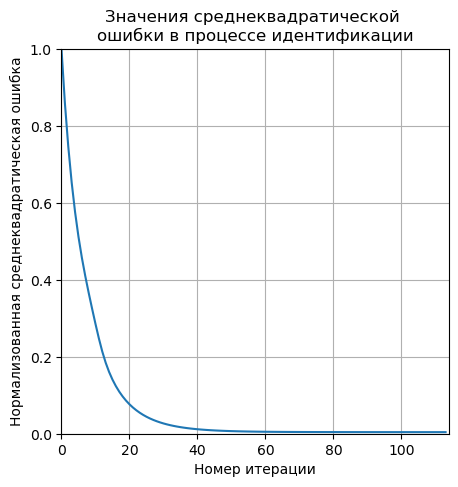

In [15]:
plot_loss_path(fs.fit_results_)
plt.show()

# K-fold Cross-Validation and hyperparameter tuning

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

indexes = np.argsort(X_train)
X_train = X_train[indexes]
y_train = y_train[indexes]

indexes = np.argsort(X_test)
X_test = X_test[indexes]
y_test = y_test[indexes]

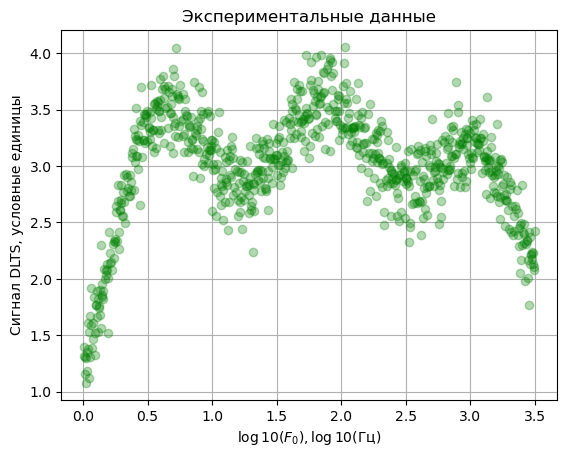

In [17]:
plot_experimental_points(X_train, y_train)
plt.show()

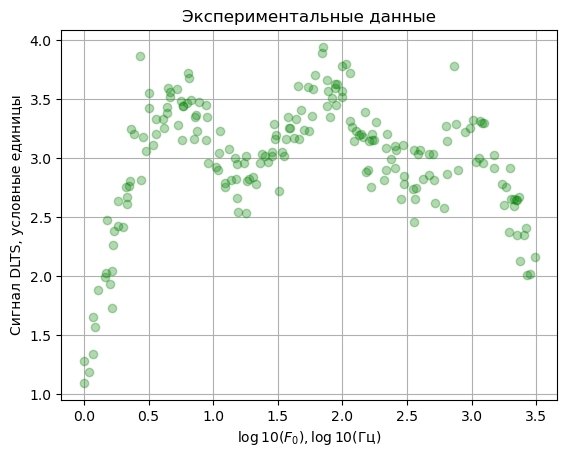

In [18]:
plot_experimental_points(X_test, y_test)
plt.show()

In [19]:
fs = SklMultiExpFrequencyScan(n_exps=2,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=2, n_iters=200,
                         stop_val=1e-05)

In [20]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.89657696 0.36114462 1.10665683 0.42391811 1.4102248  1.89910235
 1.59446824 1.28358645 1.66444358 1.74611816]
Mean: 1.2386240091875416
Standard deviation: 0.5100318737661955


In [21]:
fs.fit_results_

,amplitude_0,amplitude_1,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,verbose
0,0.285331,0.336615,0.00002,0.1,8.035452,2,200,0.00001,-2.333150,-3.200734,False
1,0.495065,0.499809,0.00002,0.1,7.344164,2,200,0.00001,-2.322722,-3.172607,False
2,0.689953,0.651635,0.00002,0.1,6.737921,2,200,0.00001,-2.302060,-3.137460,False
3,0.871101,0.793200,0.00002,0.1,6.203269,2,200,0.00001,-2.270488,-3.100054,False
4,1.039729,0.925410,0.00002,0.1,5.728288,2,200,0.00001,-2.228225,-3.063915,False
...,...,...,...,...,...,...,...,...,...,...,...
100,3.978036,3.757623,0.00002,0.1,0.696948,2,200,0.00001,-1.142635,-2.788924,False
101,3.978829,3.758438,0.00002,0.1,0.696936,2,200,0.00001,-1.142616,-2.788998,False
102,3.979581,3.759208,0.00002,0.1,0.696924,2,200,0.00001,-1.142597,-2.789069,False
103,3.980294,3.759935,0.00002,0.1,0.696914,2,200,0.00001,-1.142579,-2.789136,False


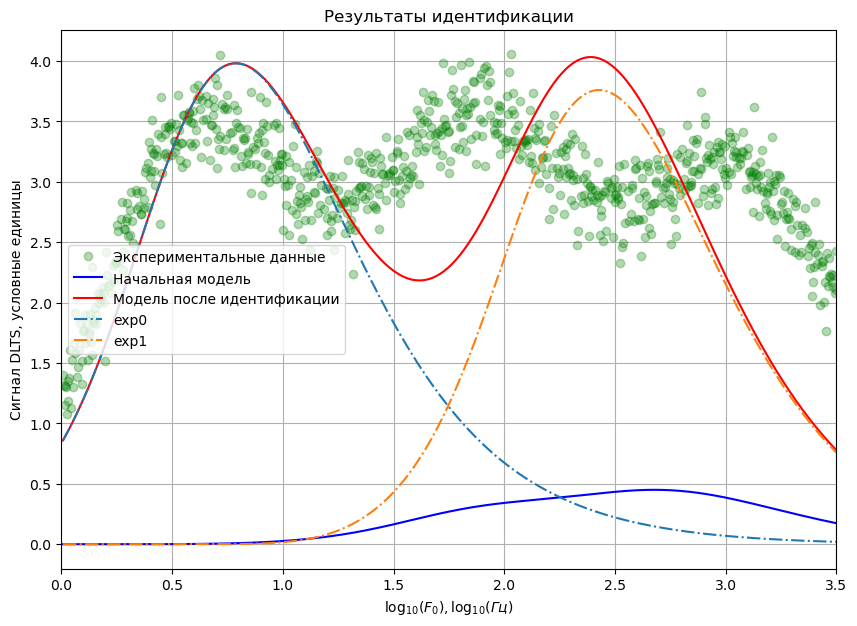

In [22]:
plot_model(X_train, y_train, SklMultiExpFrequencyScan, fs.fit_results_)

plt.show()

In [23]:
fs = SklMultiExpFrequencyScan(n_exps=5,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.23713305 0.44921317 0.22896966 0.22261692 0.20169417 0.22058819
 0.23244202 0.21734445 0.3045012  0.19026627]
Mean: 0.25047690935797273
Standard deviation: 0.07221700135797034


In [24]:
grid_search = GridSearchCV(fs, {'n_exps':[2,3,4,5]}, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=5,
                                                n_iters=200, stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [2, 3, 4, 5]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
grid_search.best_params_

{'n_exps': 3}

In [27]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

2.107253686577215 {'n_exps': 2}
0.4828726962868676 {'n_exps': 3}
0.634781687868689 {'n_exps': 4}
0.5105364022722036 {'n_exps': 5}


In [28]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.17308283 0.19558075 0.2237914  0.20073397 0.19487542 0.23860035
 0.20904629 0.22516245 0.19652365 0.17735072]
Mean: 0.20347478358611246
Standard deviation: 0.019865042888893174


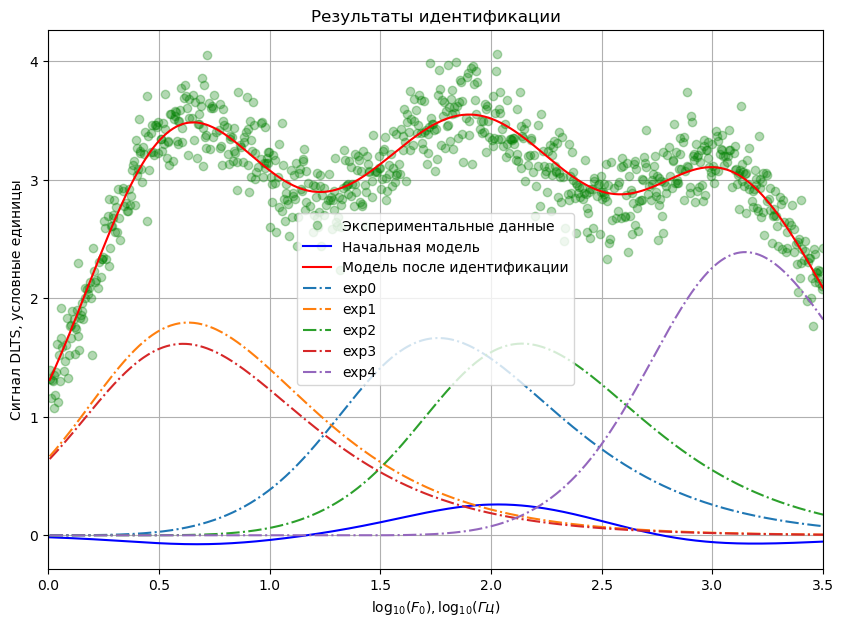

In [29]:
fit_results = grid_search.best_estimator_.fit_results_

plot_model(X_train, y_train, SklMultiExpFrequencyScan, fs.fit_results_)

plt.show()

In [30]:
mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test), squared=False)

0.1911146086079545